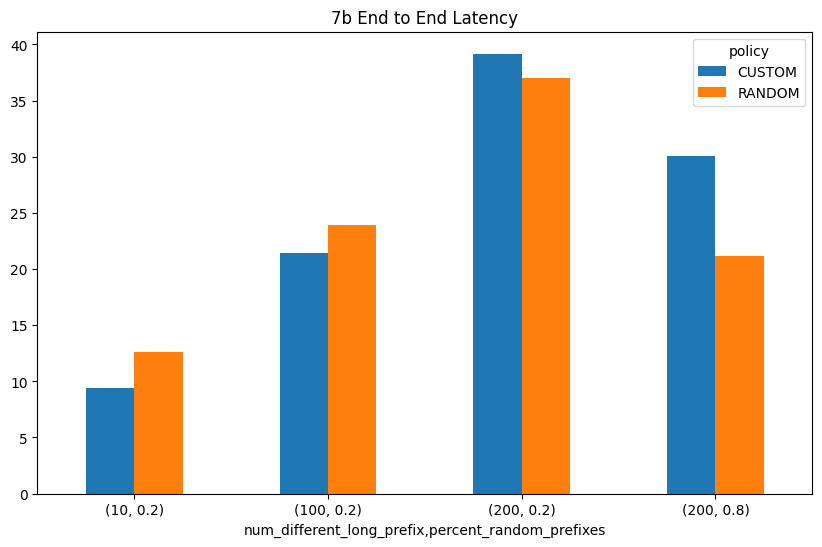

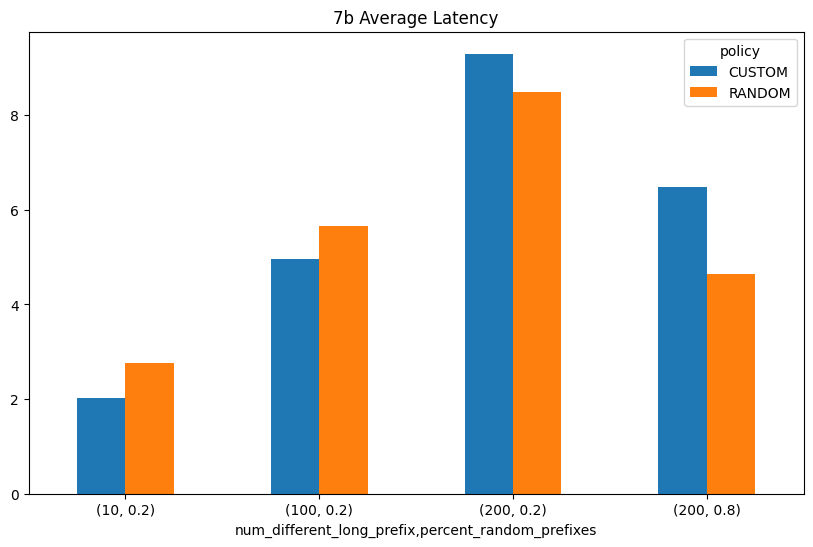

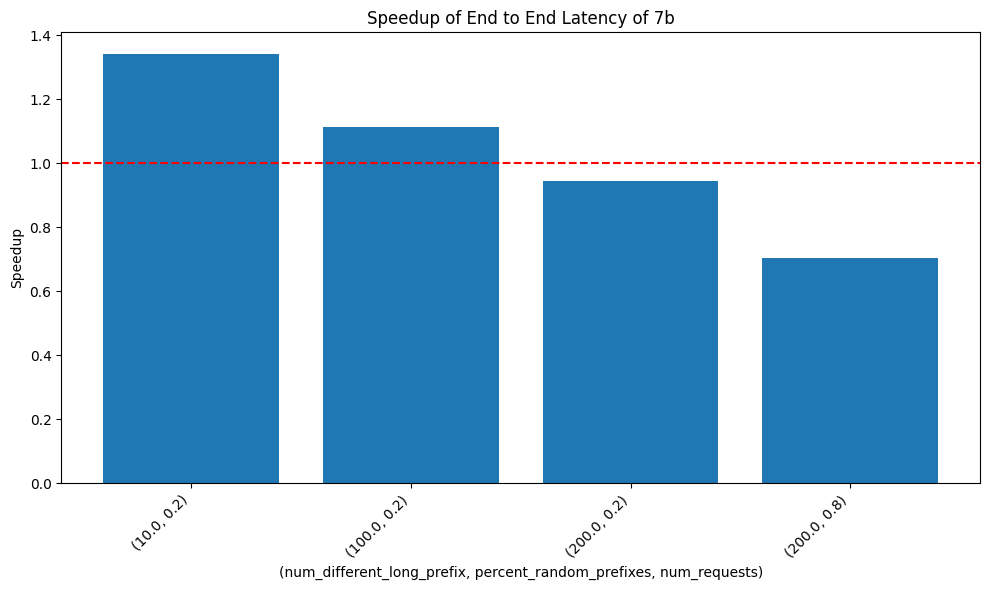

In [9]:
import re
import matplotlib.pyplot as plt
import pandas as pd

def extract_policy_and_number(log_file):
    overall_latencies = []
    request_latencies = []
    with open(log_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Extract lines containing overall latency
            if 'Overall Latency' in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Latency: (.*)', line)
                if match:
                    overall_latencies.append({
                        "model_name": match.group(1),
                        "num_different_long_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "policy": match.group(5),
                        "latency": float(match.group(6))
                    })
            elif "Overall Request Latency:" in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Request Latency: (.*), STD: (.*), P90: (.*)', line)
                if match:
                    request_latencies.append({
                        "model_name": match.group(1),
                        "num_different_long_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "policy": match.group(5),
                        "avg_latency": float(match.group(6)),
                        "std": float(match.group(7)),
                        "p90": float(match.group(8))
                    })                

    return overall_latencies, request_latencies

log_file = 'experiment_7b_with_gpu_ids.log'
result, request_latencies = extract_policy_and_number(log_file)

df = pd.DataFrame(result)
df = df.drop("num_requests", axis=1)
df = df.drop("model_name", axis=1)
df = df.groupby(['num_different_long_prefix', 'percent_random_prefixes', 'policy'])['latency'].mean().unstack()
df.plot(kind='bar', figsize=(10, 6), title="7b End to End Latency", rot=0)

request_latency_df = pd.DataFrame(request_latencies)
request_latency_df = request_latency_df.drop("model_name", axis=1).drop("num_requests", axis=1)
request_latency_df = request_latency_df.groupby(['num_different_long_prefix', 'percent_random_prefixes', 'policy'])["avg_latency"].mean().unstack()
request_latency_df.plot(kind='bar', figsize=(10, 6), title="7b Average Latency", rot=0)


df["Speedup"] = df["RANDOM"] / df["CUSTOM"]
df = df.reset_index()
labels = df.apply(lambda x: f'({x["num_different_long_prefix"]}, {x["percent_random_prefixes"]})', axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, df['Speedup'])
plt.title('Speedup of End to End Latency of 7b')
plt.xlabel('(num_different_long_prefix, percent_random_prefixes, num_requests)')
plt.ylabel('Speedup')
ax.axhline(y=1.0, color='r', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [10]:
import re

def parse_input(input_file):
    all_group_info = []

    with open(input_file, 'r') as file:
        chunk_started = False
        gpu_cache_hit_rates = []
        current_policy = ""
        num_workloads = 0
        num_shared = 0
        num_requests = 0
        num_requests_gpu0 = 0
        num_requests_gpu1 = 0

        for line in file:
            if line.startswith('DEBUG:root:=====STARTING Policy'):
                if chunk_started:
                    # Calculate average cache hit rate for each GPU
                    avg_cache_hit_rate_gpu_0 = sum(hit_rate for gpu_id, hit_rate in gpu_cache_hit_rates if gpu_id == 0) / num_requests_gpu0 if num_requests_gpu0 else 0
                    avg_cache_hit_rate_gpu_1 = sum(hit_rate for gpu_id, hit_rate in gpu_cache_hit_rates if gpu_id == 1) / num_requests_gpu1 if num_requests_gpu1 else 0
                    # Store all relevant information for this group
                    group_info = {
                        # "gpu_cache_hit_rates": gpu_cache_hit_rates,
                        "avg_cache_tree_hit_rate_gpu_0": avg_cache_hit_rate_gpu_0,
                        "avg_cache_tree_hit_rate_gpu_1": avg_cache_hit_rate_gpu_1,
                        "current_policy": current_policy,
                        "num_workloads": num_workloads,
                        "num_shared": num_shared,
                        "num_requests": num_requests,
                        "num_requests_gpu0": num_requests_gpu0,
                        "num_requests_gpu1": num_requests_gpu1
                    }
                    all_group_info.append(group_info)

                # Initialize variables for new group
                chunk_started = True
                gpu_cache_hit_rates = []
                match = re.search(r'DataParallelRuntimeSelectionPolicy\.(.+?), (\d+) WORKLOADS, ([\d.]+) NON-SHARED, (\d+) REQUESTS', line)
                if match:
                    current_policy = match.group(1)
                    num_workloads = int(match.group(2))
                    num_shared = float(match.group(3))
                    num_requests = int(match.group(4))
                num_requests_gpu0 = 0
                num_requests_gpu1 = 0
            elif chunk_started:
                match = re.search(r'GPU (\d+):.*?tree_cache_hit_rate: (\d+\.\d+)%', line)
                if match:
                    gpu_id = int(match.group(1))
                    tree_cache_hit_rate = float(match.group(2))
                    gpu_cache_hit_rates.append((gpu_id, tree_cache_hit_rate))
                    if gpu_id == 0:
                        num_requests_gpu0 += 1
                    elif gpu_id == 1:
                        num_requests_gpu1 += 1

        # Calculate average cache hit rate for the last group
        avg_cache_hit_rate_gpu_0 = sum(hit_rate for gpu_id, hit_rate in gpu_cache_hit_rates if gpu_id == 0) / num_requests_gpu0
        avg_cache_hit_rate_gpu_1 = sum(hit_rate for gpu_id, hit_rate in gpu_cache_hit_rates if gpu_id == 1) / num_requests_gpu1
        # Store all relevant information for the last group
        group_info = {
            # "gpu_cache_hit_rates": gpu_cache_hit_rates,
            "avg_cache_tree_hit_rate_gpu_0": avg_cache_hit_rate_gpu_0,
            "avg_cache_tree_hit_rate_gpu_1": avg_cache_hit_rate_gpu_1,
            "current_policy": current_policy,
            "num_workloads": num_workloads,
            "num_shared": num_shared,
            "num_requests": num_requests,
            "num_requests_gpu0": num_requests_gpu0,
            "num_requests_gpu1": num_requests_gpu1
        }
        all_group_info.append(group_info)

    return all_group_info
parse_input('experiment_7b_with_gpu_ids.log')

[{'avg_cache_tree_hit_rate_gpu_0': 77.22117647058823,
  'avg_cache_tree_hit_rate_gpu_1': 44.65,
  'current_policy': 'RANDOM',
  'num_workloads': 10,
  'num_shared': 0.2,
  'num_requests': 1024,
  'num_requests_gpu0': 51,
  'num_requests_gpu1': 7},
 {'avg_cache_tree_hit_rate_gpu_0': 83.08687500000002,
  'avg_cache_tree_hit_rate_gpu_1': 56.557500000000005,
  'current_policy': 'CUSTOM',
  'num_workloads': 10,
  'num_shared': 0.2,
  'num_requests': 1024,
  'num_requests_gpu0': 32,
  'num_requests_gpu1': 8},
 {'avg_cache_tree_hit_rate_gpu_0': 80.64435897435897,
  'avg_cache_tree_hit_rate_gpu_1': 54.3275,
  'current_policy': 'RANDOM',
  'num_workloads': 10,
  'num_shared': 0.2,
  'num_requests': 1024,
  'num_requests_gpu0': 39,
  'num_requests_gpu1': 8},
 {'avg_cache_tree_hit_rate_gpu_0': 64.30111111111111,
  'avg_cache_tree_hit_rate_gpu_1': 86.66568181818181,
  'current_policy': 'CUSTOM',
  'num_workloads': 10,
  'num_shared': 0.2,
  'num_requests': 1024,
  'num_requests_gpu0': 9,
  'num_re

In [ ]:
import re

def parse_input(input_file):
    all_group_info = []

    with open(input_file, 'r') as file:
        chunk_started = False
        gpu_cache_hit_rates = []
        current_policy = ""
        num_workloads = 0
        num_shared = 0
        num_requests = 0
        num_requests_gpu0 = 0
        num_requests_gpu1 = 0

        for line in file:
            if line.startswith('DEBUG:root:=====STARTING Policy'):
                if chunk_started:
                    # Calculate average cache hit rate for each GPU
                    avg_cache_hit_rate_gpu_0 = sum(hit_rate for gpu_id, hit_rate in gpu_cache_hit_rates if gpu_id == 0) / num_requests_gpu0 if num_requests_gpu0 else 0
                    avg_cache_hit_rate_gpu_1 = sum(hit_rate for gpu_id, hit_rate in gpu_cache_hit_rates if gpu_id == 1) / num_requests_gpu1 if num_requests_gpu1 else 0
                    # Store all relevant information for this group
                    group_info = {
                        # "gpu_cache_hit_rates": gpu_cache_hit_rates,
                        "avg_cache_tree_hit_rate_gpu_0": avg_cache_hit_rate_gpu_0,
                        "avg_cache_tree_hit_rate_gpu_1": avg_cache_hit_rate_gpu_1,
                        "current_policy": current_policy,
                        "num_workloads": num_workloads,
                        "num_shared": num_shared,
                        "num_requests": num_requests,
                        "num_requests_gpu0": num_requests_gpu0,
                        "num_requests_gpu1": num_requests_gpu1
                    }
                    all_group_info.append(group_info)

                # Initialize variables for new group
                chunk_started = True
                gpu_cache_hit_rates = []
                match = re.search(r'DataParallelRuntimeSelectionPolicy\.(.+?), (\d+) WORKLOADS, ([\d.]+) NON-SHARED, (\d+) REQUESTS', line)
                if match:
                    current_policy = match.group(1)
                    num_workloads = int(match.group(2))
                    num_shared = float(match.group(3))
                    num_requests = int(match.group(4))
                num_requests_gpu0 = 0
                num_requests_gpu1 = 0
            elif chunk_started:
                match = re.search(r'GPU (\d+):.*?tree_cache_hit_rate: (\d+\.\d+)%', line)
                if match:
                    gpu_id = int(match.group(1))
                    tree_cache_hit_rate = float(match.group(2))
                    gpu_cache_hit_rates.append((gpu_id, tree_cache_hit_rate))
                    if gpu_id == 0:
                        num_requests_gpu0 += 1
                    elif gpu_id == 1:
                        num_requests_gpu1 += 1

        # Calculate average cache hit rate for the last group
        avg_cache_hit_rate_gpu_0 = sum(hit_rate for gpu_id, hit_rate in gpu_cache_hit_rates if gpu_id == 0) / num_requests_gpu0
        avg_cache_hit_rate_gpu_1 = sum(hit_rate for gpu_id, hit_rate in gpu_cache_hit_rates if gpu_id == 1) / num_requests_gpu1
        # Store all relevant information for the last group
        group_info = {
            # "gpu_cache_hit_rates": gpu_cache_hit_rates,
            "avg_cache_tree_hit_rate_gpu_0": avg_cache_hit_rate_gpu_0,
            "avg_cache_tree_hit_rate_gpu_1": avg_cache_hit_rate_gpu_1,
            "current_policy": current_policy,
            "num_workloads": num_workloads,
            "num_shared": num_shared,
            "num_requests": num_requests,
            "num_requests_gpu0": num_requests_gpu0,
            "num_requests_gpu1": num_requests_gpu1
        }
        all_group_info.append(group_info)

    return all_group_info
parse_input('experiment_7b_with_gpu_ids.log')

[{'avg_cache_tree_hit_rate_gpu_0': 77.22117647058823,
  'avg_cache_tree_hit_rate_gpu_1': 44.65,
  'current_policy': 'RANDOM',
  'num_workloads': 10,
  'num_shared': 0.2,
  'num_requests': 1024,
  'num_requests_gpu0': 51,
  'num_requests_gpu1': 7},
 {'avg_cache_tree_hit_rate_gpu_0': 83.08687500000002,
  'avg_cache_tree_hit_rate_gpu_1': 56.557500000000005,
  'current_policy': 'CUSTOM',
  'num_workloads': 10,
  'num_shared': 0.2,
  'num_requests': 1024,
  'num_requests_gpu0': 32,
  'num_requests_gpu1': 8},
 {'avg_cache_tree_hit_rate_gpu_0': 80.64435897435897,
  'avg_cache_tree_hit_rate_gpu_1': 54.3275,
  'current_policy': 'RANDOM',
  'num_workloads': 10,
  'num_shared': 0.2,
  'num_requests': 1024,
  'num_requests_gpu0': 39,
  'num_requests_gpu1': 8},
 {'avg_cache_tree_hit_rate_gpu_0': 64.30111111111111,
  'avg_cache_tree_hit_rate_gpu_1': 86.66568181818181,
  'current_policy': 'CUSTOM',
  'num_workloads': 10,
  'num_shared': 0.2,
  'num_requests': 1024,
  'num_requests_gpu0': 9,
  'num_re

,model_name,num_different_long_prefix,percent_random_prefixes,num_requests,policy,avg_latency,std,p90
0,mistralai/Mistral-7B-v0.1,10,0.2,1024,RANDOM,2.376601,2.217583,5.152500
1,mistralai/Mistral-7B-v0.1,10,0.2,1024,CUSTOM,2.772433,2.554340,7.045356
2,mistralai/Mistral-7B-v0.1,10,0.2,1024,RANDOM,2.562353,2.544942,5.517009
3,mistralai/Mistral-7B-v0.1,10,0.2,1024,CUSTOM,2.483837,2.422991,6.496345
4,mistralai/Mistral-7B-v0.1,100,0.2,1024,RANDOM,5.599401,5.423637,12.383520
5,mistralai/Mistral-7B-v0.1,100,0.2,1024,CUSTOM,4.412746,3.993864,9.494186
6,mistralai/Mistral-7B-v0.1,200,0.2,1024,RANDOM,8.302675,7.525902,17.720655
7,mistralai/Mistral-7B-v0.1,200,0.2,1024,CUSTOM,9.279927,8.792880,23.735251
8,mistralai/Mistral-7B-v0.1,200,0.8,1024,RANDOM,4.934036,3.828111,10.864939
9,mistralai/Mistral-7B-v0.1,200,0.8,1024,CUSTOM,5.985472,6.017194,16.293710


In [ ]:
# Test with worst case prefix
# Investigation the cache hits a bit more/eviction(why we perform worse than other system)
#     always re-compute the prefix? 
